## Abbeville, LA 2022 City Council and Mayoral Election Results and Boundaries

### Sections
- <a href="#join">Read in Input Files and Join</a><br>
- <a href="#shp">Create Ward Boundaries</a><br>
- <a href="#maup">Join with Election Returns</a><br>
- <a href="#exp">Export Cleaned Datasets</a><br>

#### Sources

- [Louisiana Secretary of State - Abbeville, LA 2022 Municipal Election Returns](https://voterportal.sos.la.gov/static/2022-03-26/resultsRace/57)) 
- [Abbeville, LA City Council Districts KML](https://www.google.com/maps/d/viewer?mid=1xOlAo0KxOxlGTTVqt9B8kMp7FcTw5fqB&ll=29.977346522059307%2C-92.1217195&z=14)
- [RDH - Louisiana 2022 General Election Precinct-Level Results and Boundaries](https://redistrictingdatahub.org/dataset/louisiana-2022-general-election-precinct-level-results/)

In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

######  RDH Function to Allocate Early Votes

In [2]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum(numeric_only=True))
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1
                            special_allocation_needed.append([race_district,race])
    if(len(special_allocation_needed) > 0):
        print("Special allocation used for", special_allocation_needed)

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum(numeric_only=True))

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

<p><a name="join"></a></p>

### Read in input files

Election returns were transcribed from Louisiana SOS website to machine readable format, and checked for accuracy.

In [3]:
#Election Returns by precinct
er_raw = pd.read_csv("./raw-from-source/LA22_ABBEVILLE_ER.csv").fillna(0)
# Add in Municipality column
er_raw['MNCIPAL'] = 'ABBEVILLE'
er_raw

,Precinct,District,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN,MNCIPAL
0,00 28,A,27,24,32,12,4,18,33,0,0,0,0,0,ABBEVILLE
1,00 29,A,92,80,64,81,14,77,93,0,0,0,0,0,ABBEVILLE
2,00 32B,A,27,37,34,23,8,32,31,0,0,0,0,0,ABBEVILLE
3,00 34,D,80,52,77,49,1,0,0,0,0,20,0,2,ABBEVILLE
4,00 34A,A,26,29,21,26,10,9,11,0,0,0,0,0,ABBEVILLE
5,00 35,C,59,108,90,51,11,0,0,113,51,0,0,0,ABBEVILLE
6,00 36A-1,A/C/D,30,23,32,17,7,1,3,24,13,5,0,3,ABBEVILLE
7,00 37,C/D,68,137,115,69,25,0,0,12,1,142,7,45,ABBEVILLE
8,00 38,D,24,95,61,52,12,0,0,0,0,78,4,41,ABBEVILLE
9,00 39,C/D,43,56,45,50,7,0,0,11,9,36,14,29,ABBEVILLE


In [4]:
vote_cols = list(er_raw.columns[2:-1])
vote_cols

['G22MYRRPLA',
 'G22MYRNWHI',
 'G22CTCDCAM',
 'G22CTCDDAR',
 'G22CTCDPOT',
 'GCTCARGAR',
 'GCTCARHAR',
 'GCTCCIBRO',
 'GCTCCRTRA',
 'GCTCDRBRO',
 'GCTCDDGRE',
 'GCTCDDLAN']

In [5]:
er_raw[vote_cols] = er_raw[vote_cols].astype(int)

In [6]:
er_rec = er_raw.iloc[:-2]
er_alloc = er_raw.iloc[-2:-1]
er_total = er_raw.iloc[-1:]
er_alloc

,Precinct,District,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN,MNCIPAL
17,Early,0,319,496,446,264,79,107,121,161,44,171,14,46,ABBEVILLE


##### Vote Allocation for Early Votes

In [7]:
er_final = allocate_absentee(er_rec,er_alloc,vote_cols,"MNCIPAL",allocating_to_all_empty_precs=False)

### Vote Totals Check

In [8]:
er_final[vote_cols].sum()

G22MYRRPLA     903
G22MYRNWHI    1303
G22CTCDCAM    1145
G22CTCDDAR     800
G22CTCDPOT     211
GCTCARGAR      280
GCTCARHAR      313
GCTCCIBRO      407
GCTCCRTRA      163
GCTCDRBRO      452
GCTCDDGRE       39
GCTCDDLAN      166
dtype: int64

In [9]:
er_total

,Precinct,District,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN,MNCIPAL
18,Total,0,903,1303,1145,800,211,280,313,407,163,452,39,166,ABBEVILLE


## LA22_ABBEVILLE_DIST

Raw KML file was read in to QGIS, and unincorporated islands were removed from two district shapes - Districts A and D

In [10]:
# Read the edited geojsons in
dist_a = gp.read_file("./raw-from-source/DIST_A_EDIT.geojson")   
dist_b = gp.read_file("./raw-from-source/DIST_B.geojson") 
dist_c = gp.read_file("./raw-from-source/DIST_C.geojson") 
dist_d = gp.read_file("./raw-from-source/DIST_D_EDIT.geojson") 

In [11]:
#combine
shp_raw = gp.GeoDataFrame(pd.concat([dist_a, dist_b, dist_c, dist_d], ignore_index=True), crs=dist_a.crs)

In [12]:
unique_id = ['ABBEVILLE_CITYCOUNC_A', 'ABBEVILLE_CITYCOUNC_B', 'ABBEVILLE_CITYCOUNC_C', 'ABBEVILLE_CITYCOUNC_D']

In [13]:
#Add unique ID col
shp_raw['UNIQUE_ID'] = unique_id
#subset
shp_dist = shp_raw[['UNIQUE_ID', 'geometry']]

In [14]:
#Check
shp_dist

,UNIQUE_ID,geometry
0,ABBEVILLE_CITYCOUNC_A,"MULTIPOLYGON Z (((-92.12449 29.97980 0.00000, ..."
1,ABBEVILLE_CITYCOUNC_B,"POLYGON Z ((-92.07829 29.96562 0.00000, -92.07..."
2,ABBEVILLE_CITYCOUNC_C,"POLYGON Z ((-92.13667 29.97661 0.00000, -92.13..."
3,ABBEVILLE_CITYCOUNC_D,"MULTIPOLYGON Z (((-92.13780 29.96532 0.00000, ..."


<AxesSubplot:>

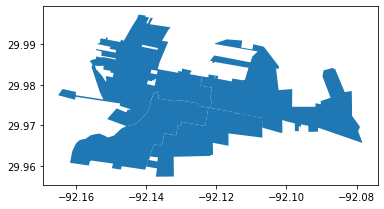

In [15]:
shp_dist.plot()

### Read in Precinct-Level Shapefile

In [16]:
# Read the shapefile in
la22 = gp.read_file("./raw-from-source/la_gen_2022_prec.shp")
verm22 = la22[la22['Parish'] == 'Vermilion'][['UNIQUE_ID', 'Precinct', 'geometry']]

In [17]:
verm22.Precinct.unique()

array(['00 01', '00 02', '00 05A', '00 06', '00 07A-1', '00 07B',
       '00 08B', '00 09', '00 10A', '00 11', '00 12', '00 14', '00 16',
       '00 18', '00 19A', '00 19A-1', '00 19B', '00 20A-2', '00 20B-1',
       '00 21', '00 21A', '00 23', '00 24', '00 25', '00 25A', '00 26',
       '00 26A', '00 28', '00 29', '00 32B', '00 34', '00 34A', '00 35',
       '00 36A-1', '00 37', '00 38', '00 39', '00 40', '00 41', '00 42A',
       '00 42B', '00 44', '00 45A', '00 46A', '00 46B-1', '00 46B-2',
       '00 46B-3', '00 46B-4', '00 49B-1', '00 49B-2', '00 50A', '00 51',
       '00 53', '00 57A', '00 57B'], dtype=object)

In [18]:
prec_list = ['00 28', '00 29', '00 32B', '00 34', '00 34A', '00 35',
       '00 36A-1', '00 37', '00 38', '00 39', '00 40','00 42A','00 46A', '00 46B-1', '00 46B-2',
       '00 46B-3', '00 46B-4']

In [19]:
abb_precs = verm22[verm22['Precinct'].isin(prec_list)]
#abb_precs.to_file("./abb_22_precs.geojson")

<AxesSubplot:>

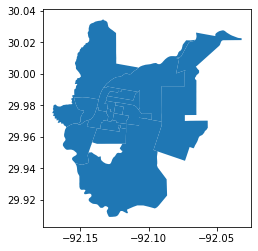

In [20]:
abb_precs.plot()

### Clip Precincts to City Boundaries

In [21]:
#check CRS of 2022 precincts file
abb_precs.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [22]:
#match crs
shp_dist = shp_dist.to_crs(4269)

In [23]:
#clip to boundaries of city
abb_precs_clip = gp.clip(abb_precs, shp_dist)

<AxesSubplot:>

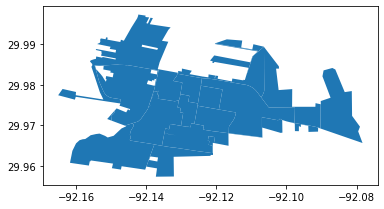

In [24]:
abb_precs_clip.plot()

### Merge with Election Returns

In [25]:
# merge
abb_pber = er_rec.merge(abb_precs_clip, on='Precinct', how = 'right', indicator=True)

In [26]:
#check indicator to see if merge was successful
abb_pber._merge.value_counts()

both          17
left_only      0
right_only     0
Name: _merge, dtype: int64

In [27]:
#Drop merge column, drop district column
abb_pber.drop(labels = ['_merge', 'District'], axis = 1, inplace = True)

In [28]:
#Capitalize Precinct column
abb_pber.rename(columns={'Precinct': 'PRECINCT'}, inplace=True)
#Redo UNIQUE_ID column
abb_pber['UNIQUE_ID'] = abb_pber['MNCIPAL'] + '-:-' + abb_pber['PRECINCT']
#Rearrange columns
abb_pber_final = abb_pber[['UNIQUE_ID', 'MNCIPAL', 'PRECINCT'] + vote_cols + ['geometry']]


In [29]:
abb_pber_final.head()

,UNIQUE_ID,MNCIPAL,PRECINCT,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN,geometry
0,ABBEVILLE-:-00 42A,ABBEVILLE,00 42A,4,3,1,4,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-92.11646 29.96805 0.00000, ..."
1,ABBEVILLE-:-00 39,ABBEVILLE,00 39,43,56,45,50,7,0,0,11,9,36,14,29,"POLYGON Z ((-92.12605 29.97149 0.00000, -92.12..."
2,ABBEVILLE-:-00 34,ABBEVILLE,00 34,80,52,77,49,1,0,0,0,0,20,0,2,"POLYGON Z ((-92.12428 29.98059 0.00000, -92.12..."
3,ABBEVILLE-:-00 34A,ABBEVILLE,00 34A,26,29,21,26,10,9,11,0,0,0,0,0,"MULTIPOLYGON Z (((-92.12527 29.97541 0.00000, ..."
4,ABBEVILLE-:-00 46B-3,ABBEVILLE,00 46B-3,1,8,1,7,2,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-92.11121 29.98290 0.00000, ..."


In [30]:
#Geodf
abb_pber_final = gp.GeoDataFrame(abb_pber_final, geometry='geometry')
#check
type(abb_pber_final)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

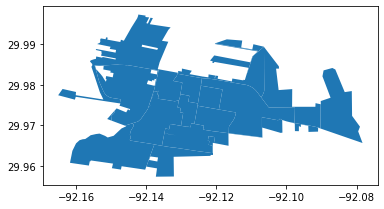

In [31]:
abb_pber_final.plot()

<p><a name="exp"></a></p>

### Export Cleaned Datasets

In [32]:
if not os.path.exists("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER"):
    os.mkdir("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER")

shp_dist.to_file("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_DIST.shp")    
abb_pber_final.to_file("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER.shp")

In [33]:
def check_file(path):
    if ".csv" in path:
        file_type = ".csv"
        load = pd.read_csv(path)
    elif ".shp" in path:
        file_type = ".shp"
        load = gp.read_file(path)
        assert(os.path.exists(path[0:-4] + ".cpg"))
        assert(os.path.exists(path[0:-4] + ".dbf"))
        assert(os.path.exists(path[0:-4] + ".prj"))
        assert(os.path.exists(path[0:-4] + ".shx"))
    else:
        raise ValueError ("Other function needed to load non .csv or .shp")
    run_checks(load, path, file_type)
    
def run_checks(file, path, file_type):
    if "/Users" in path:
        path = path.replace("/Users","")
    path_name = path.replace("/","-")
    
        
    with open("./FILE_CHECK" + path_name + ".txt","w") as t:
        t.write("***RDH FILE CHECKER***\n")
        t.write("Checking file located at " + path+"\n")
        t.write("\n")
        t.write("\n")        
        
        t.write("***N/A VALUES***\n")
        if(file.isna().any().sum() != 0):
            t.write("N/A values in the following columns\n")
            for col in file.columns:
                num_nas = file[col].isna().sum()
                string_nans = file[file[col]=="nan"].shape[0]
                if file[col].isna().any().sum():
                    t.write("\t"+col+" - "+ str(num_nas) +" row(s)\n")
                elif  string_nans > 0:
                    t.write("\t"+col+" - "+ str(string_nans) +" row(s)\n")

        else:
            t.write("Do not appear to be N/A values")
        t.write("\n")
        t.write("\n")
        
        t.write("***File Size***\n")
        t.write("File contains " + str(file.shape[0]) + " row(s)\n")
        t.write("File contains " + str(file.shape[1]) + " column(s)\n")
        t.write("\n")
        t.write("\n")
        
        if file_type == ".shp":
            t.write("***Invalid Geometries***\n")
            t.write("File contains " + str(file[~file["geometry"].is_valid].shape[0]) + " invalid GEOM row(s)\n")
            t.write("File contains " + str(file[file["geometry"].is_valid].shape[0]) + " valid GEOM row(s)\n")
            t.write("\n")
            t.write("\n")

        t.write("***COLUMN NAMES***\n")
        t.write(str(list(file.columns)))
        t.write("\n")
        t.write("\n")
        
        t.write("***COLUMN NAME LENGTHS***\n")
        long_col_name_list = [i for i in file.columns if len(i) > 10]
        if len(long_col_name_list) > 0:
            t.write("The following columns are longer than 10 characters:" + str(long_col_name_list)+"\n")
        else:
            t.write("No column names are longer than 10 characters\n")
        t.write("\n")
        t.write("\n")

        t.write("***FULL FILE SUMMARY***\n")
        t.write(str(file.describe())+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***MAX VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.max()) + "\n")
        t.write("\n")
        t.write("\n")

        t.write("***MIN VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.min()) + "\n")
        t.write("\n")
        
        t.write("***NUMERIC COLUMN SUMS***\n")
        t.write(str(file.sum(numeric_only=True))+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***COLUMNS AND DUPLICATE VALUES***\n")
        for col in list(file.columns):
            if col != "geometry":
                if max(file[col].value_counts(dropna = False))==1:
                    t.write("NO: Column " + col + " DOES NOT HAVE duplicate values\n")
                elif max(file[col].value_counts(dropna = False))>1:
                    t.write("YES: Column " + col+ " HAS duplicate values\n")
        t.write("\n")


In [34]:
check_file("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER.shp")